In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
import pickle
import time
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error

import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

sns.set_theme()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load data

In [7]:
data = pd.read_pickle('../data/data_neutron_photonsum_p_2133_n_15_3273.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

# Data containing particle conditional data from particle having responses with proton photon sum in interval [70, 2312] without taking into consideration photon sums of neutron responses.
data_cond = pd.read_pickle('../data/data_cond_stddev_photonsum_p_15_2133_n_15_3273.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (48714, 44, 44) max: 532.0
Loaded cond:  (48714, 15) max: 7000.0 min: -7000.0


In [3]:
data = pd.read_pickle('../data/data_proton_photonsum_proton_1_2312.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_1_2312.pkl')
print('Loaded cond: ',  data_cond.shape, "max:", data_cond.values.max(), "min:", data_cond.values.min())

Loaded:  (344228, 56, 30) max: 765.0
Loaded cond:  (344228, 11) max: 7000.0 min: -7000.0


In [4]:
from random import randint

In [44]:
x = [int(randint(10, 500)) for _ in range(10)]

In [49]:
data_cond[['Energy', 'mass', 'charge', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'std_proton', 'std_neutron']].iloc[x].to_excel('excel_data_sdi_gan.xlsx')

### Function for calculating sum of channels

In [5]:
from utils.utils import get_channel_masks, sum_channels_parallel

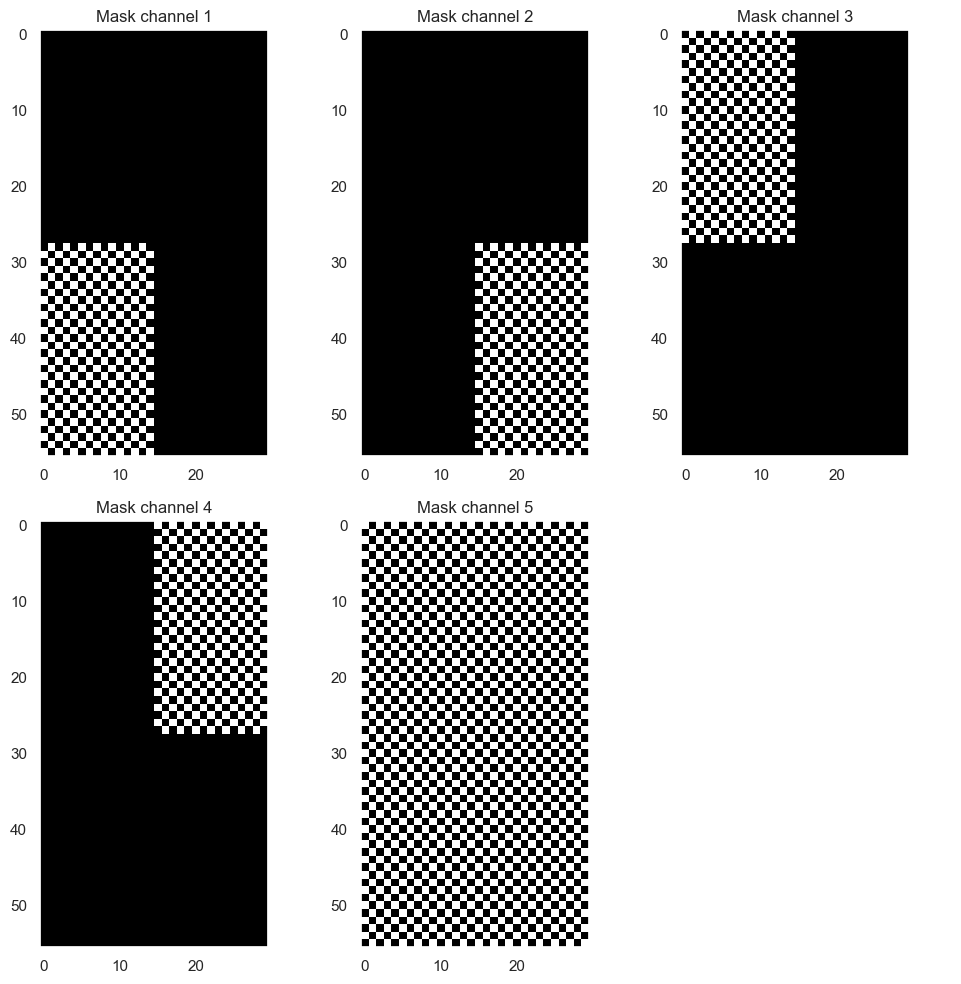

In [6]:
# PROTON

mask1, mask2, mask3, mask4, mask5 = get_channel_masks(data[0])

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 10))
ax1.imshow(mask1, origin="upper", cmap='gray'); ax1.set_title("Mask channel 1");
ax2.imshow(mask2, origin="upper", cmap='gray'); ax2.set_title("Mask channel 2");
ax3.imshow(mask3, origin="upper", cmap='gray'); ax3.set_title("Mask channel 3");
ax4.imshow(mask4, origin="upper", cmap='gray'); ax4.set_title("Mask channel 4");
ax5.imshow(mask5, origin="upper", cmap='gray'); ax5.set_title("Mask channel 5");
ax6.axis('off')
# plt.suptitle("Proton dataset channel masks")
plt.tight_layout()
ax1.grid(False), ax2.grid(False), ax3.grid(False), ax4.grid(False), ax5.grid(False)
plt.savefig("Thesis images/proton_channel_masks.png")

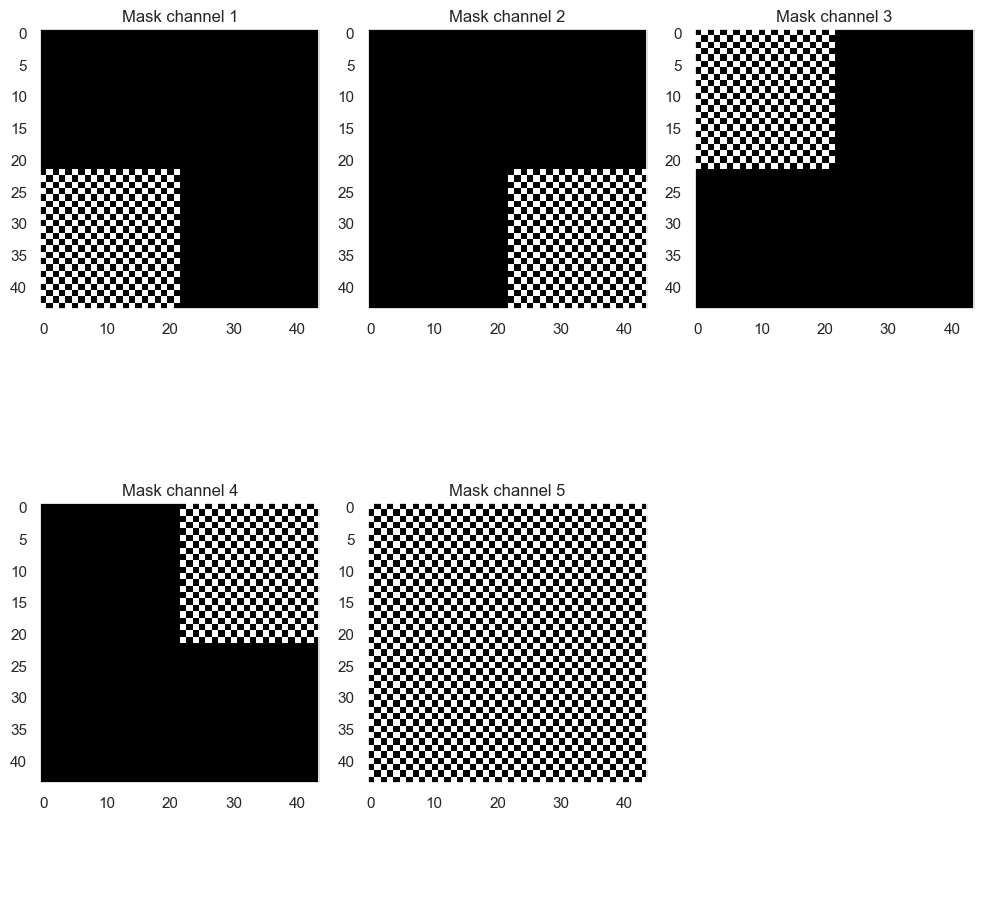

In [10]:
# NEUTRON

mask1, mask2, mask3, mask4, mask5 = get_channel_masks(data[0])

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 10))
ax1.imshow(mask1, origin="upper", cmap='gray'); ax1.set_title("Mask channel 1");
ax2.imshow(mask2, origin="upper", cmap='gray'); ax2.set_title("Mask channel 2");
ax3.imshow(mask3, origin="upper", cmap='gray'); ax3.set_title("Mask channel 3");
ax4.imshow(mask4, origin="upper", cmap='gray'); ax4.set_title("Mask channel 4");
ax5.imshow(mask5, origin="upper", cmap='gray'); ax5.set_title("Mask channel 5");
ax6.axis('off')
# plt.suptitle("Neutron dataset channel masks")
plt.tight_layout()
ax1.grid(False), ax2.grid(False), ax3.grid(False), ax4.grid(False), ax5.grid(False)
plt.savefig("Thesis images/neutron_channel_masks.png")

### Old channel sum for neutron data

In [12]:
coords = np.ogrid[0:data.shape[1], 0:data.shape[2]]
half_x = data.shape[1]//2
half_y = data.shape[2]//2

checkerboard = (coords[0] + coords[1]) % 2 != 0
checkerboard.reshape(-1,checkerboard.shape[0], checkerboard.shape[1])

ch5 = (data*checkerboard).sum(axis=1).sum(axis=1)

checkerboard = (coords[0] + coords[1]) % 2 == 0
checkerboard =checkerboard.reshape(-1,checkerboard.shape[0], checkerboard.shape[1])

mask1 = np.zeros((1,data.shape[1],data.shape[2]))
mask1[:,:half_x,:half_y] = checkerboard[:,:half_x,:half_y]
ch1 = (data*mask1).sum(axis=1).sum(axis=1)

mask2 = np.zeros((1,data.shape[1],data.shape[2]))
mask2[:,:half_x,half_y:] = checkerboard[:,:half_x,half_y:]
ch2 = (data*mask2).sum(axis=1).sum(axis=1)

mask3 = np.zeros((1,data.shape[1],data.shape[2]))
mask3[:,half_x:,:half_y] = checkerboard[:,half_x:,:half_y]
ch3 = (data*mask3).sum(axis=1).sum(axis=1)

mask4 = np.zeros((1,data.shape[1],data.shape[2]))
mask4[:,half_x:,half_y:] = checkerboard[:,half_x:,half_y:]
ch4 = (data*mask4).sum(axis=1).sum(axis=1)

mask5 = np.ones((1,data.shape[1],data.shape[2]))
mask5 = mask5 - checkerboard[:,:,:]

ValueError: operands could not be broadcast together with shapes (32951,56,44,2) (56,44) 

NameError: name 'mask1' is not defined

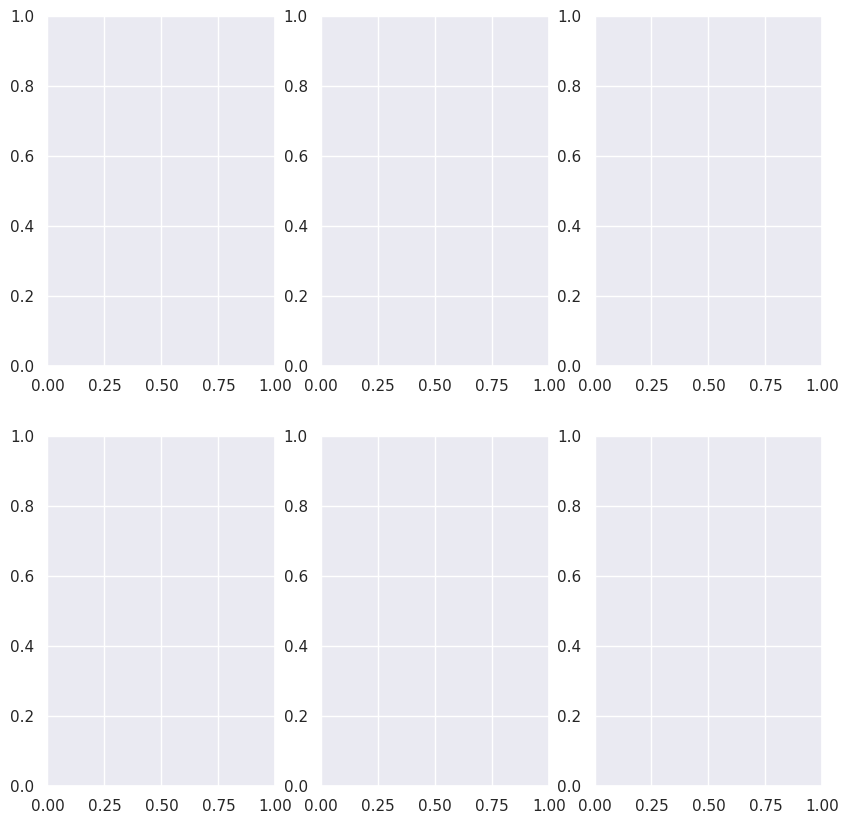

In [13]:
fig, ((ax1, ax2, ax3), (ax4, ax5, _)) = plt.subplots(2, 3, figsize=(10, 10))

ax1.imshow(mask1[0], origin="lower", cmap='gray'); ax1.set_title("Mask channel 1");
ax2.imshow(mask2[0], origin="lower", cmap='gray'); ax2.set_title("Mask channel 2");
ax3.imshow(mask3[0], origin="lower", cmap='gray'); ax3.set_title("Mask channel 3");
ax4.imshow(mask4[0], origin="lower", cmap='gray'); ax4.set_title("Mask channel 4");
ax5.imshow(mask5[0], origin="lower", cmap='gray'); ax5.set_title("Mask channel 5");

#### Get data info for plots

In [22]:
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()
photon_sum_neutron_min, photon_sum_neutron_max = data_cond.neutron_photon_sum.min(), data_cond.neutron_photon_sum.max()

In [35]:
data_cond

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton,std_neutron,neutron_photon_sum,proton_photon_sum,group_number_proton,group_number_neutron
0,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.477884,0.131516,55.0,1195.0,275,275
1,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.097154,0.716880,1122.0,23.0,199,199
2,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.132449,0.266155,230.0,78.0,228,228
3,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.104508,0.364880,655.0,34.0,101,101
4,4144.25,0.000000e+00,0.000000e+00,0.000000e+00,0.339171,1.352870,-4144.24,939.565413,0.0,0.074378,0.315074,413.0,28.0,285,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32946,1456.66,7.796760e-18,2.269230e-18,-4.065040e-14,0.279388,0.081315,-1456.66,497.611000,0.0,0.064568,0.598369,446.0,24.0,85,85
32947,3812.18,0.000000e+00,0.000000e+00,0.000000e+00,0.052953,0.402807,-3812.18,938.272081,1.0,0.365061,0.148777,73.0,811.0,265,265
32948,1422.39,1.182560e-05,-1.385700e-06,3.655780e-02,0.511508,-0.052227,1422.39,0.000000,0.0,0.048795,0.100312,138.0,22.0,84,84
32949,4071.23,0.000000e+00,0.000000e+00,0.000000e+00,0.089305,0.069410,-4071.23,1115.683000,0.0,0.491409,0.841660,34.0,1246.0,280,280


In [23]:
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum', 'Pdg'], inplace=True)

KeyError: "['Pdg'] not found in axis"

In [24]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.403574 min 0.0


In [25]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()
# scale cond datascaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
print("cond max", y_train.max(), "min", y_train.min())

(26360, 56, 44, 2) (6591, 56, 44, 2) (26360, 15) (6591, 15)
cond max 39.35081060792358 min -77.36589109271856


### Calculate channels for original simulation test data

In [27]:
from utils import sum_channels_parallel
org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,56,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
# del org

In [28]:
org.shape

(6591, 56, 44, 2)

### Define functions for making histograms

In [30]:
def calculate_ws_ch(generator, n_calc=5, scale=1, noise_std=1):
    """
    Calculates ws distance for each channel separately.
    """
    ws = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1
        results = results * scale

        ch_gen = np.array(results).reshape(-1, 56, 44)
        ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
        for i in range(5):
            ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
        ws = np.array(ws)

    ws = ws / n_calc
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.2f}', end=" ")


def make_histograms(NAME, model, scale=1, noise_std=1):
    generator = tf.keras.models.load_model(model, compile=False)
    
    z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
    z_c = y_test
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 44)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    original=ch_org
    vae=ch_gen

    fig, axis = plt.subplots(5, 1, figsize=(10, 14), sharex=False, sharey=False)
    fig.suptitle(NAME, x=0.1, horizontalalignment='left')

    for i in range(5):
        bins = np.linspace(0, 1500, 250)
        axis[i].set_title("Kanał "+str(i+1))
        axis[i].hist(original[:,i], bins, alpha=0.5, label='true', color="red")
        axis[i].hist(vae[:,i], bins, alpha=0.5, label='generated', color="blue")
        axis[i].legend(loc='upper right')
        axis[i].set_ylabel('Liczba przykładów')
        axis[i].set_xlabel('Wartość kanału')
        axis[i].set_yscale('log')

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    fig.savefig("hist_orig.png")
    plt.show()
    
    calculate_ws_ch(generator, 5, scale,  noise_std)

## VAE

Proton data

In [78]:
MODEL_FILEPATH = "../experiments/vae_15_2133_24_03_2023_15_14/models/gen_vae_161.h5"

305/305 [==============================] - 1s 4ms/step


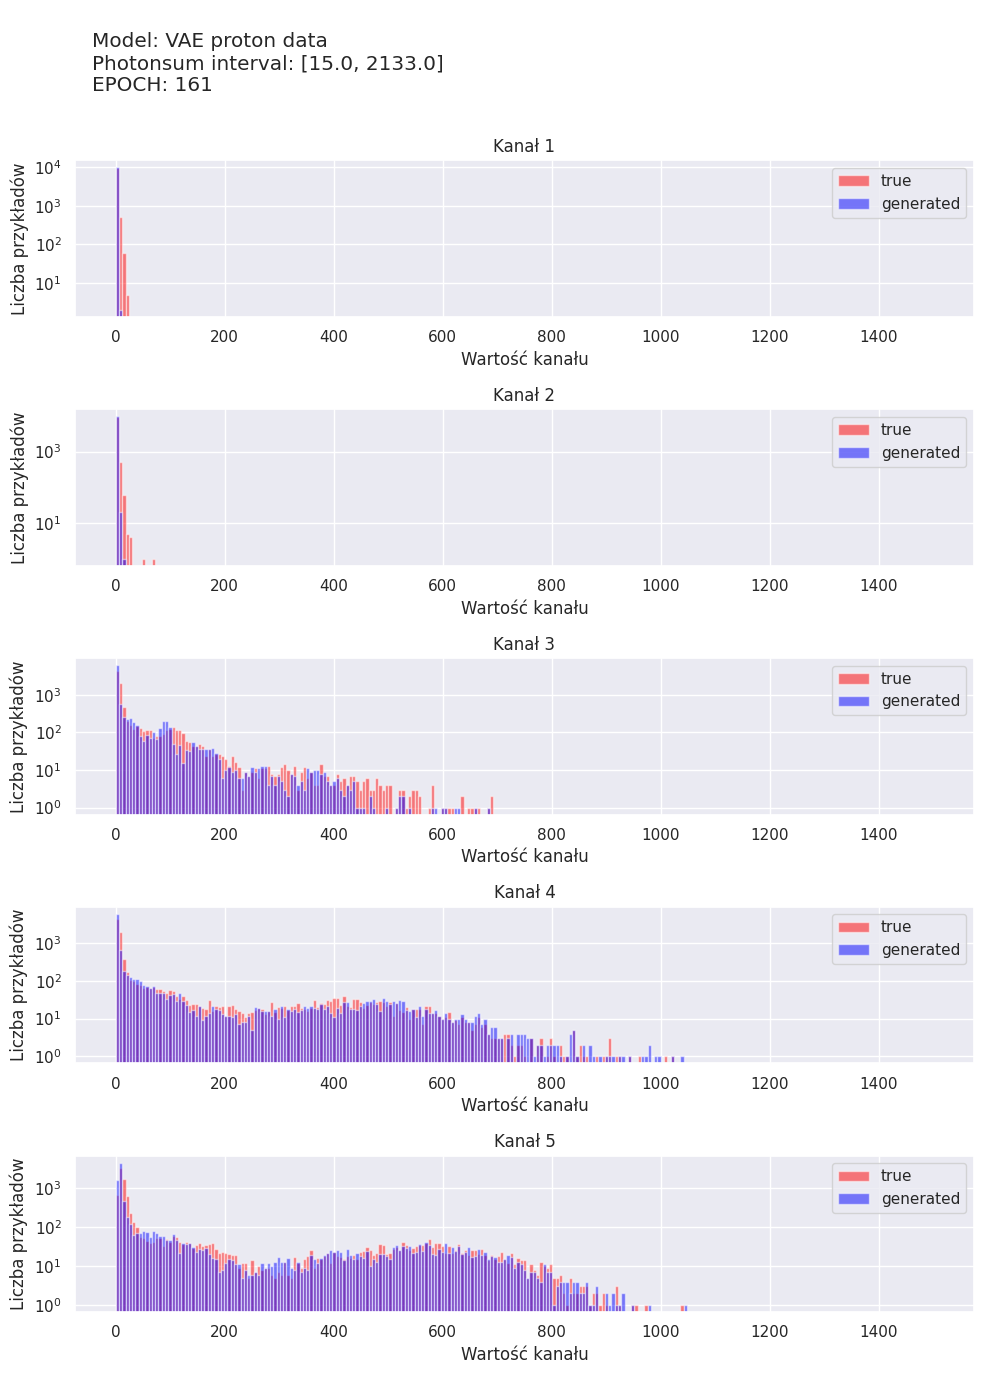

305/305 [==============================] - 1s 3ms/step

 ------------------------------ 

ws mean 7.20 ch1 0.73 ch2 0.68 ch3 9.57 ch4 8.29 ch5 16.71 

In [79]:
SUPTITLE_TXT = f"\nModel: VAE proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: 161"

make_histograms(SUPTITLE_TXT, MODEL_FILEPATH, 1, 1)

In [15]:
scale,  noise_std = 1, 1

generator = tf.keras.models.load_model(MODEL_FILEPATH, compile=False)
calculate_ws_ch(generator, 5, scale,  noise_std)

z = np.random.normal(0,noise_std,(x_test.shape[0],10))
z_c = y_test
results = generator.predict([z,z_c])
results = np.exp(results)-1
results = results*scale

ch_gen = np.array(results).reshape(-1,56,30)
ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
original=ch_org
vae=ch_gen

256/256 [==============================] - 15s 60ms/step

 ------------------------------ 

256/256 [==============================] - 15s 60ms/step


### Sample plots

In [15]:
generator = tf.keras.models.load_model(MODEL_FILEPATH, compile=False)

def generate_and_save_images(model, epoch, test_input):

    SUPTITLE_TXT = f"\nModel: VAE proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).

    predictions = model(test_input, training=False)

    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[START_GENERATING_IMG_FROM_IDX+i].reshape(56, 30)
        else:
            x = predictions[i-7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.show()

## Examples of central particle response

In [17]:
num_examples_to_generate = 16

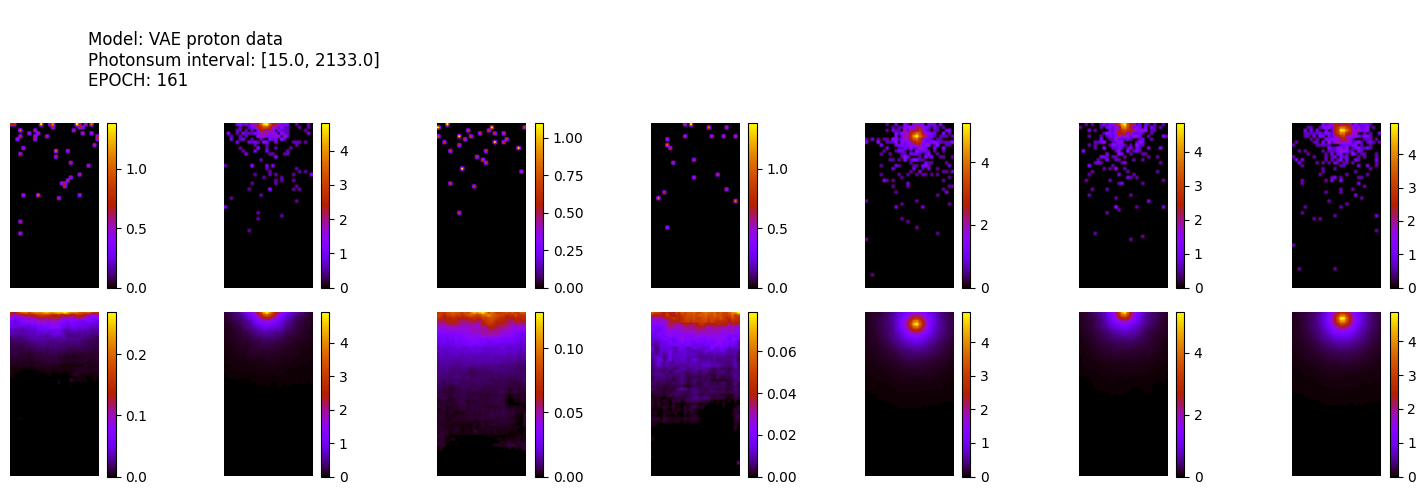

In [18]:
START_GENERATING_IMG_FROM_IDX = 252

seed = tf.random.normal([16, 10])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

generate_and_save_images(generator, 161, [seed, seed_cond])

## Examples of calorimeter not in point responses 

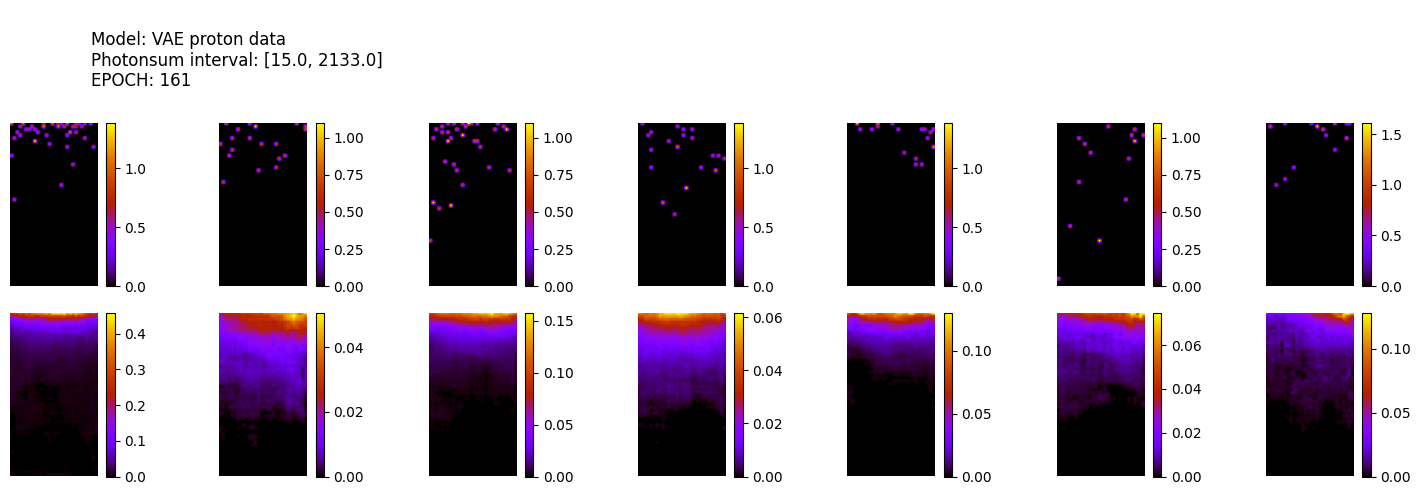

In [19]:
START_GENERATING_IMG_FROM_IDX = 50
seed = tf.random.normal([16, 10])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

generate_and_save_images(generator, 161, [seed, seed_cond])

### Fixing interference by randomizing responses

In [20]:
def get_randomized_image(predictions):
    # Introduce randomization #

    # Generate a random tensor with the same shape as image
    rand_tensor = tf.random.uniform(shape=predictions.shape, minval=0, maxval=1)

    # find pixels lower than 1
    mask_lower_than_1 = tf.cast(predictions < tf.ones_like(predictions), tf.bool)
    # in case of the existing models, all generated pixels meet this property (lower than 1)

    # Create a boolean mask indicating which elements of image should be replaced
    mask_pred_greater_than_random = tf.cast(predictions > rand_tensor, tf.bool)

    # Create final mask
    mask = mask_lower_than_1 & mask_pred_greater_than_random

    # Create a new tensor by selecting elements from image where mask is True, and elements from max_tensor where mask is False
    randomized_preds = tf.where(mask, tf.ones_like(predictions), predictions)

    return randomized_preds

In [21]:
def generate_and_save_images_randomized_responses(model, epoch, test_input):
    SUPTITLE_TXT = f"\nModel: VAE proton data with randomization" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    predictions = model(test_input, training=False)

    randomized_preds = get_randomized_image(predictions)

    fig, axs = plt.subplots(3, 7, figsize=(15, 8))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 21):
        if i < 7:
            row = 0
            x = x_test[START_GENERATING_IMG_FROM_IDX+i].reshape(56, 30)
        elif i >= 7 and i < 14:
            row = 1
            x = predictions[i-7].numpy().reshape(56, 30)
        else:
            row = 2
            x = randomized_preds[i-14].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[row, i % 7].imshow(x, cmap='gnuplot')
        axs[row, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    # set titles for each row
    axs[0, 3].set_title('Original responses', fontsize=10)
    axs[1, 3].set_title('Model predictions', fontsize=10)
    axs[2, 3].set_title('Randomized', fontsize=10)
    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.show()

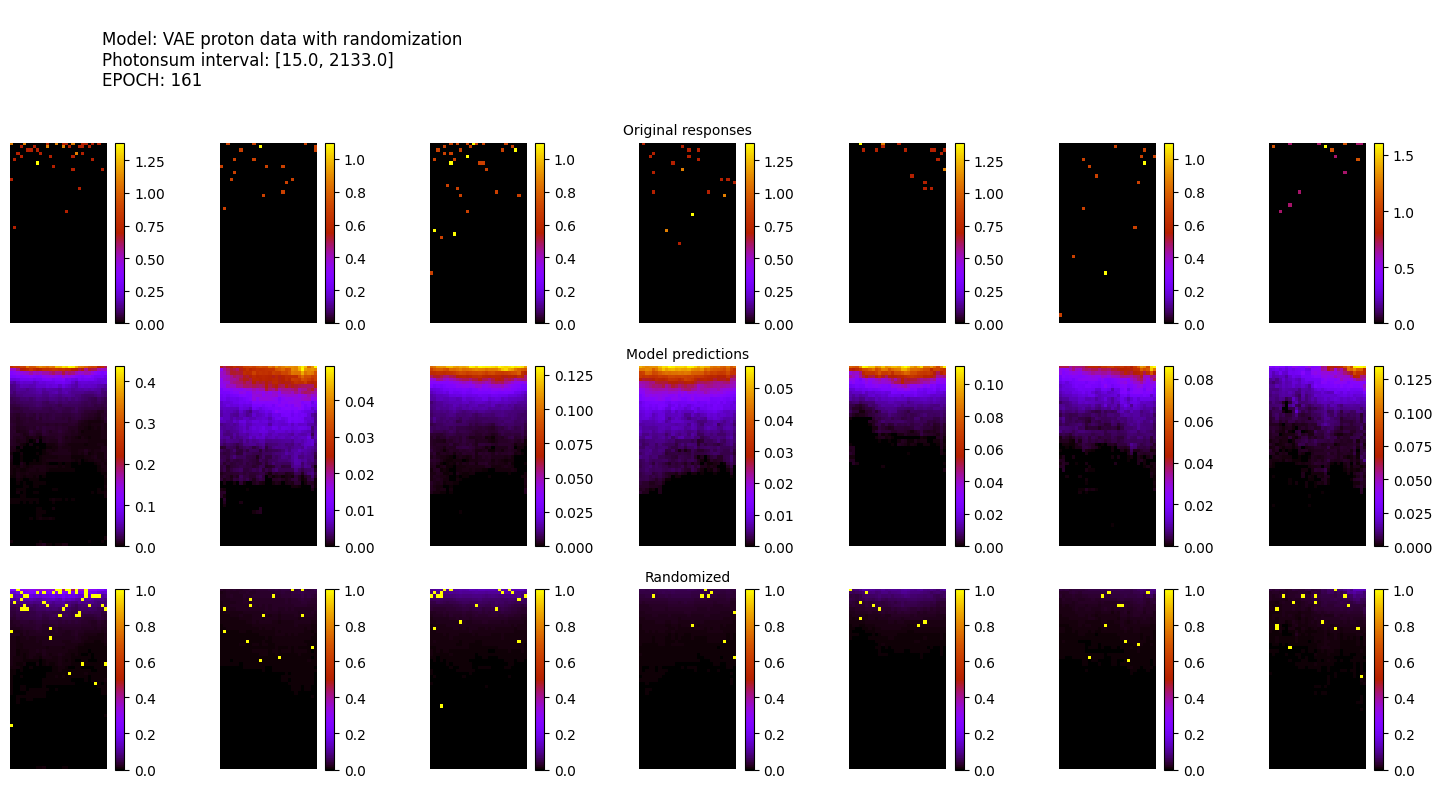

In [22]:
START_GENERATING_IMG_FROM_IDX = 50
seed = tf.random.normal([16, 10])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

generate_and_save_images_randomized_responses(generator, 161, [seed, seed_cond])

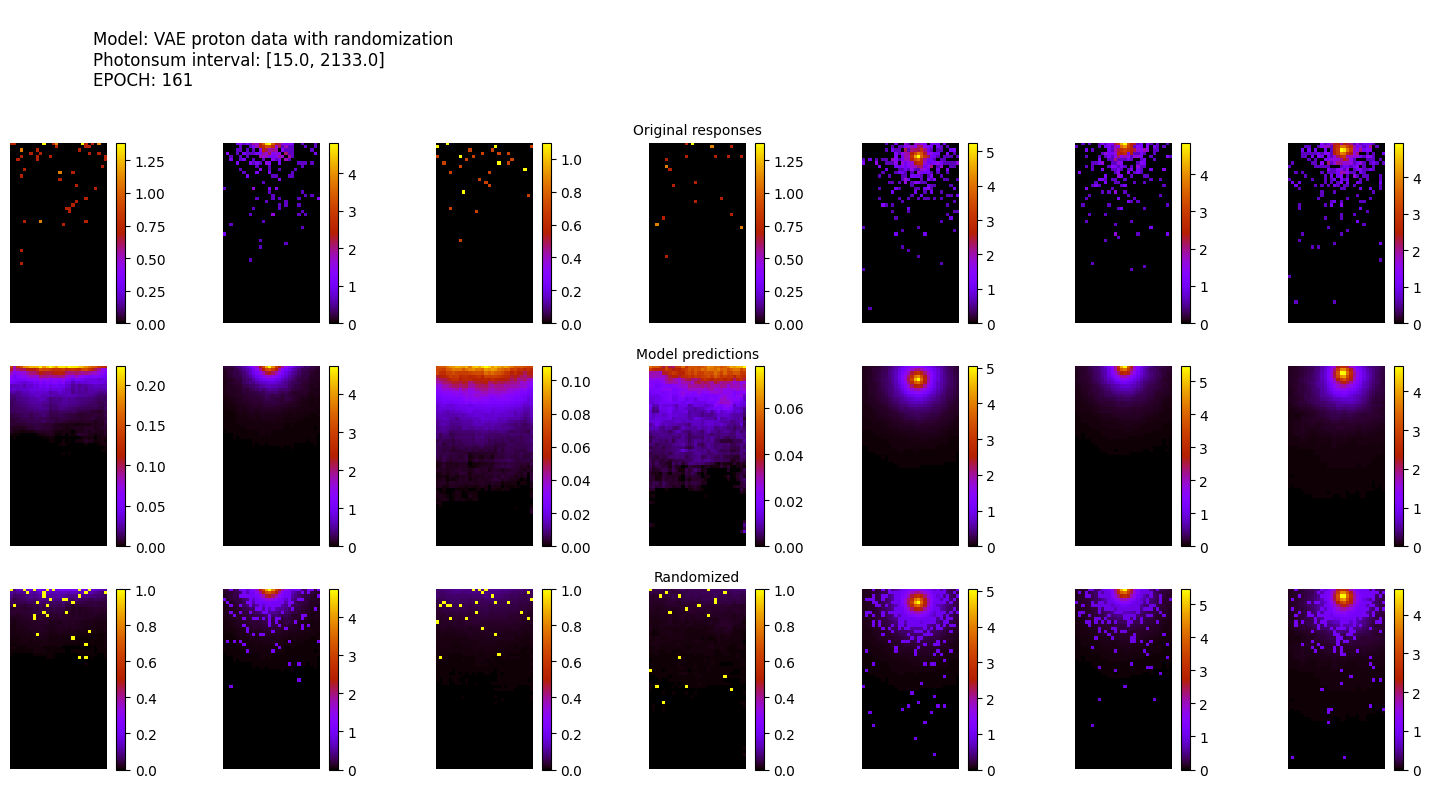

In [23]:
START_GENERATING_IMG_FROM_IDX = 252
seed = tf.random.normal([16, 10])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

generate_and_save_images_randomized_responses(generator, 161, [seed, seed_cond])

### Histograms

In [58]:
def calculate_ws_ch_randomized_responses(generator, n_calc=5, scale=1, noise_std=1):
    """
    Calculates ws distance for each channel separately.
    """
    ws = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1
        results = results * scale

        randomized_preds = get_randomized_image(results)

        ch_gen = np.array(randomized_preds).reshape(-1, 56, 30)
        ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
        for i in range(5):
            ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
        ws = np.array(ws)

    ws = ws / n_calc
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.2f}', end=" ")


def make_histograms_randomized_responses(NAME, model, scale=1, noise_std=1):
    generator = tf.keras.models.load_model(model, compile=False)

    z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
    z_c = y_test
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    randomized_preds = get_randomized_image(results)

    ch_gen = np.array(randomized_preds).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    original=ch_org
    vae=ch_gen

    fig, axis = plt.subplots(5, 1, figsize=(10, 14), sharex=False, sharey=False)
    fig.suptitle(NAME, x=0.1, horizontalalignment='left')

    for i in range(5):
        bins = np.linspace(0, 1500, 250)
        axis[i].set_title("Kanał "+str(i+1))
        axis[i].hist(original[:,i], bins, alpha=0.5, label='true', color="red")
        axis[i].hist(vae[:,i], bins, alpha=0.5, label='generated', color="blue")
        axis[i].legend(loc='upper right')
        axis[i].set_ylabel('Liczba przykładów')
        axis[i].set_xlabel('Wartość kanału')
        axis[i].set_yscale('log')

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    fig.savefig("randomized.png")
    plt.show()
    
    calculate_ws_ch_randomized_responses(generator, 5, scale,  noise_std)

305/305 [==============================] - 1s 4ms/step


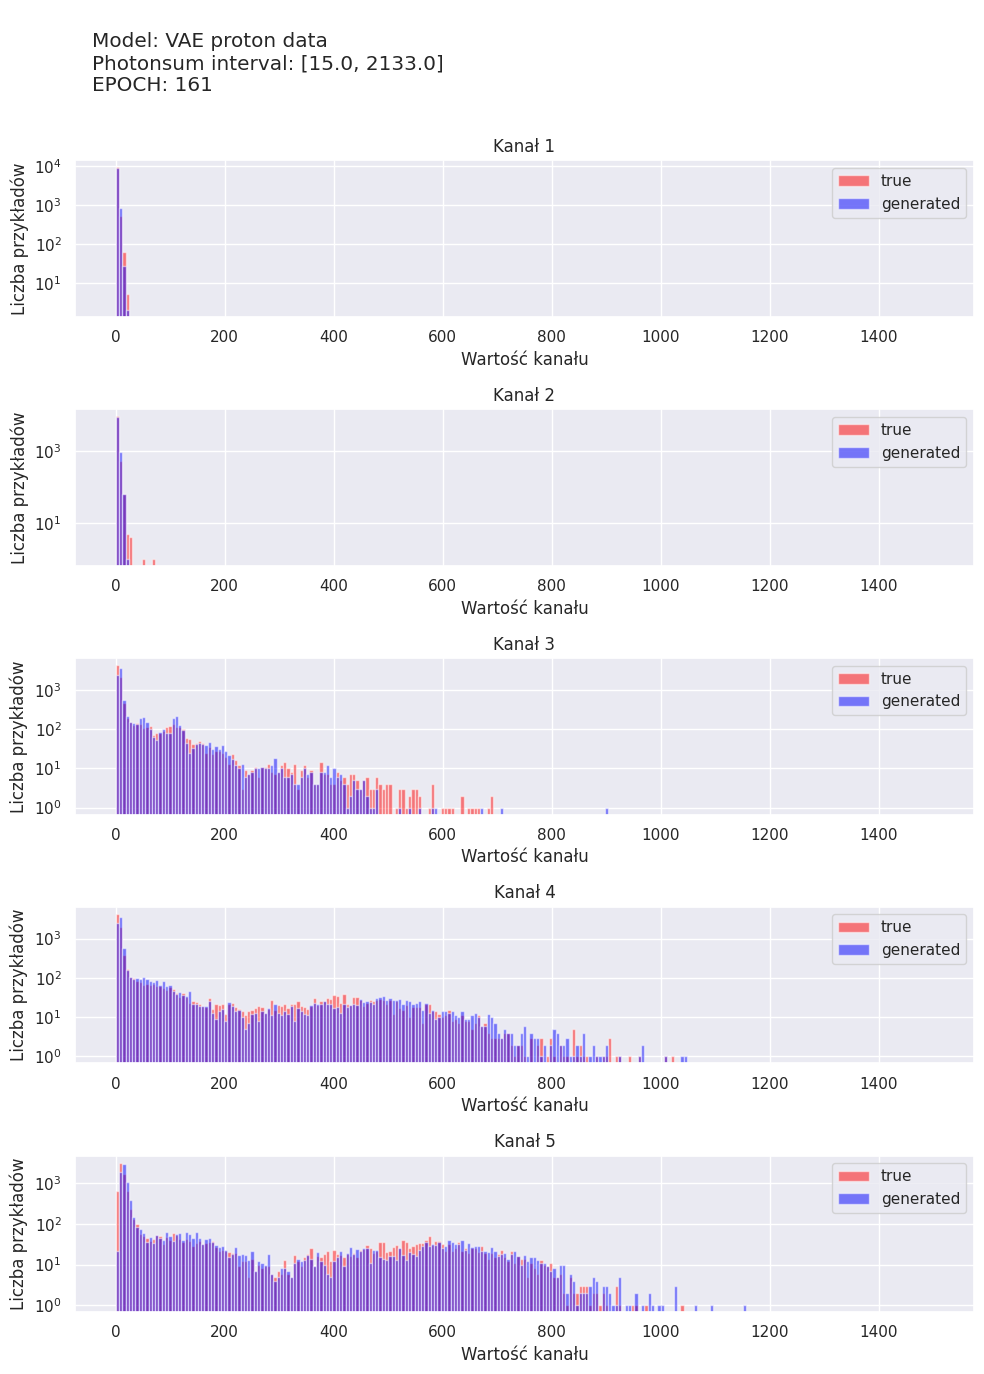

305/305 [==============================] - 1s 3ms/step

 ------------------------------ 

ws mean 4.27 ch1 0.37 ch2 0.43 ch3 4.11 ch4 7.27 ch5 9.18 

In [59]:
SUPTITLE_TXT = f"\nModel: VAE proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: 161"

make_histograms_randomized_responses(SUPTITLE_TXT, MODEL_FILEPATH, 1, 1)

## SDI-GAN

Proton data

In [13]:
MODEL_FILEPATH = "../experiments/sdi-gan_15_2133_08_05_2023_21_20/models/gen_sdi-gan_62.h5"

305/305 [==============================] - 6s 13ms/step


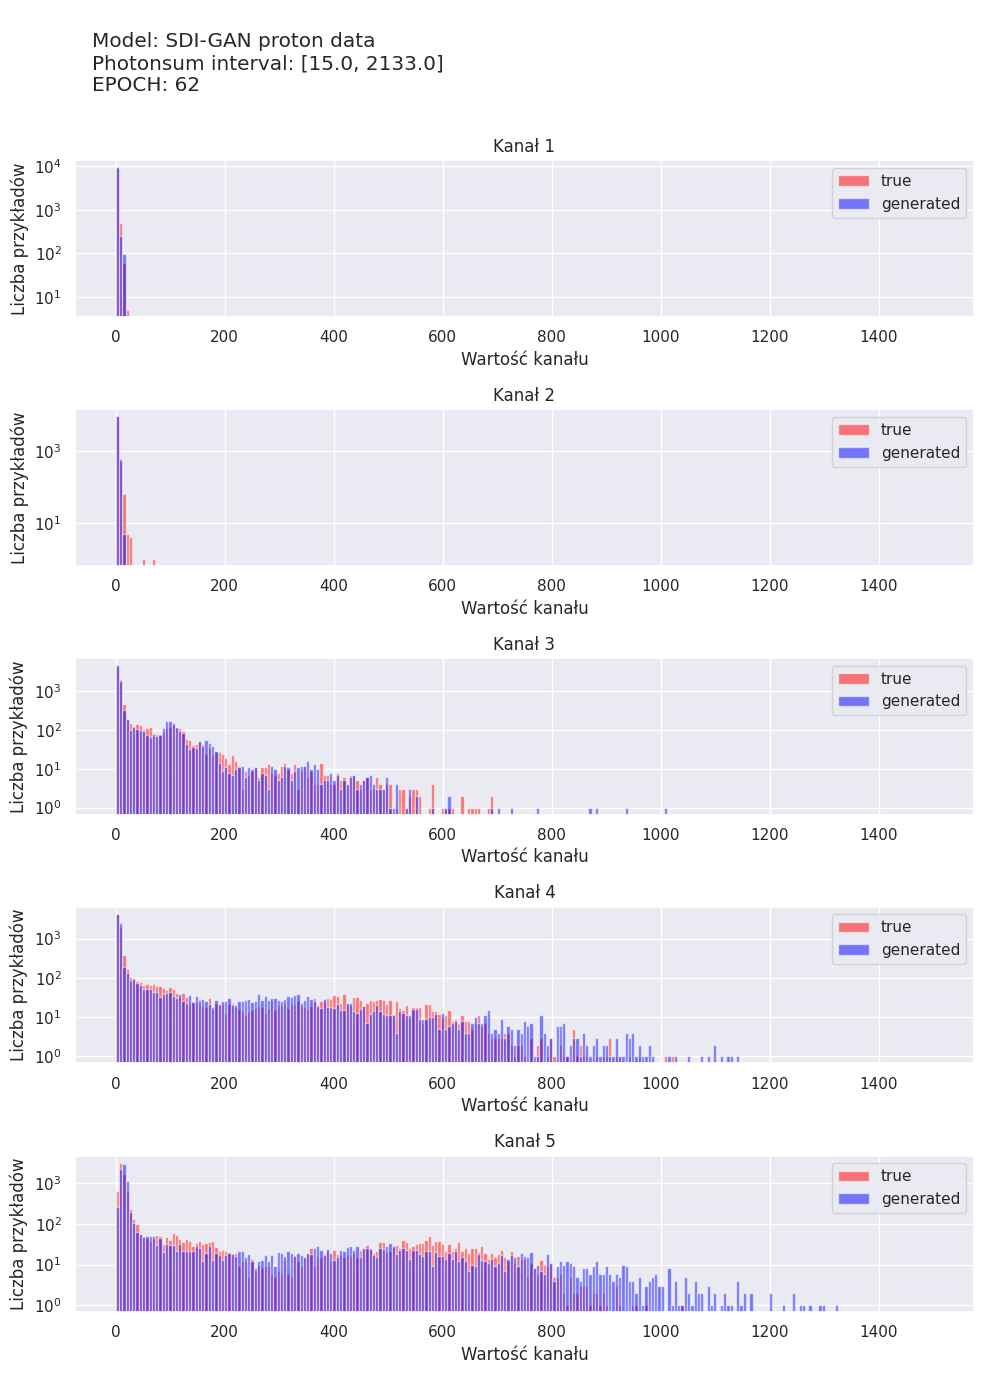

305/305 [==============================] - 4s 12ms/step

 ------------------------------ 

ws mean 5.81 ch1 0.45 ch2 0.57 ch3 2.85 ch4 9.11 ch5 16.06 

In [14]:
SUPTITLE_TXT = f"\nModel: SDI-GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: 62"

make_histograms(SUPTITLE_TXT, MODEL_FILEPATH, 1, 1)

### Sample plots

In [16]:
generator = tf.keras.models.load_model(MODEL_FILEPATH, compile=False)

def generate_and_save_images(model, epoch, test_input):

    SUPTITLE_TXT = f"\nModel: SDI-GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).

    predictions = model(test_input, training=False)

    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[START_GENERATING_IMG_FROM_IDX+i].reshape(56, 30)
        else:
            x = predictions[i-7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.show()

## Examples of central particle response

In [17]:
num_examples_to_generate = 16

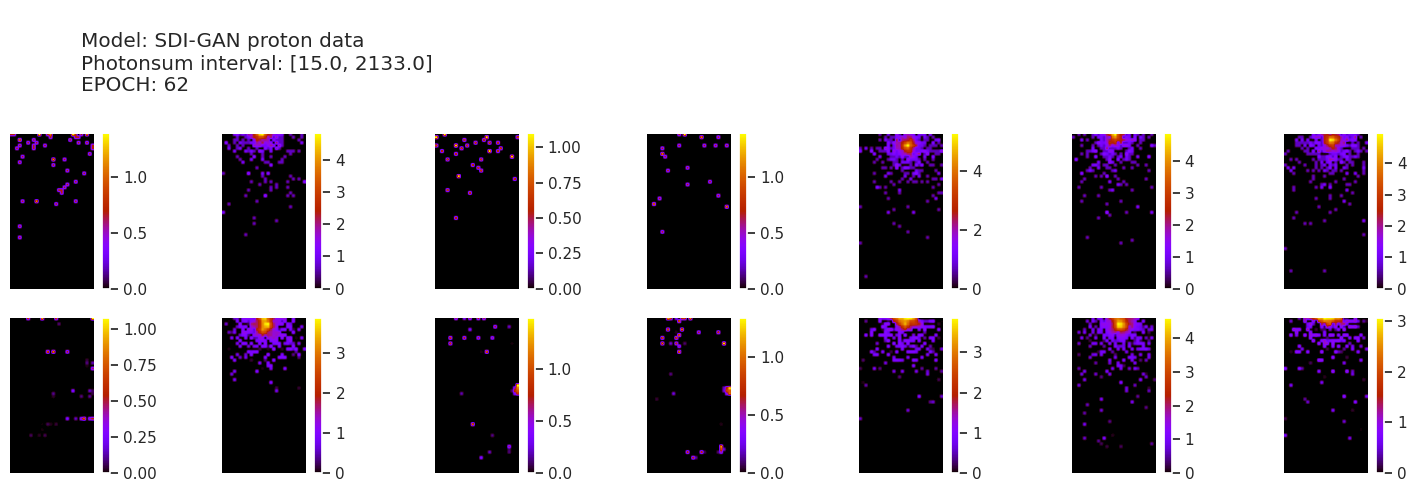

In [18]:
START_GENERATING_IMG_FROM_IDX = 252

seed = tf.random.normal([16, 10])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

generate_and_save_images(generator, 62, [seed, seed_cond])

## Examples of calorimeter not in point responses 

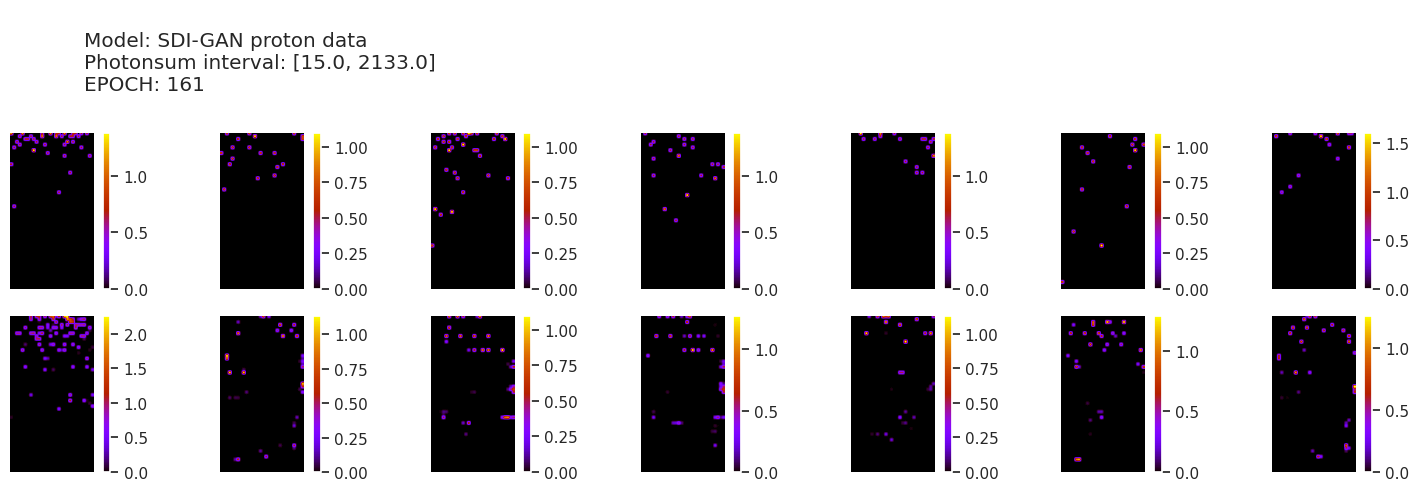

In [19]:
START_GENERATING_IMG_FROM_IDX = 50
seed = tf.random.normal([16, 10])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

generate_and_save_images(generator, 161, [seed, seed_cond])

### GAN

Proton data

305/305 [==============================] - 17s 57ms/step

 ------------------------------ 

305/305 [==============================] - 17s 57ms/step


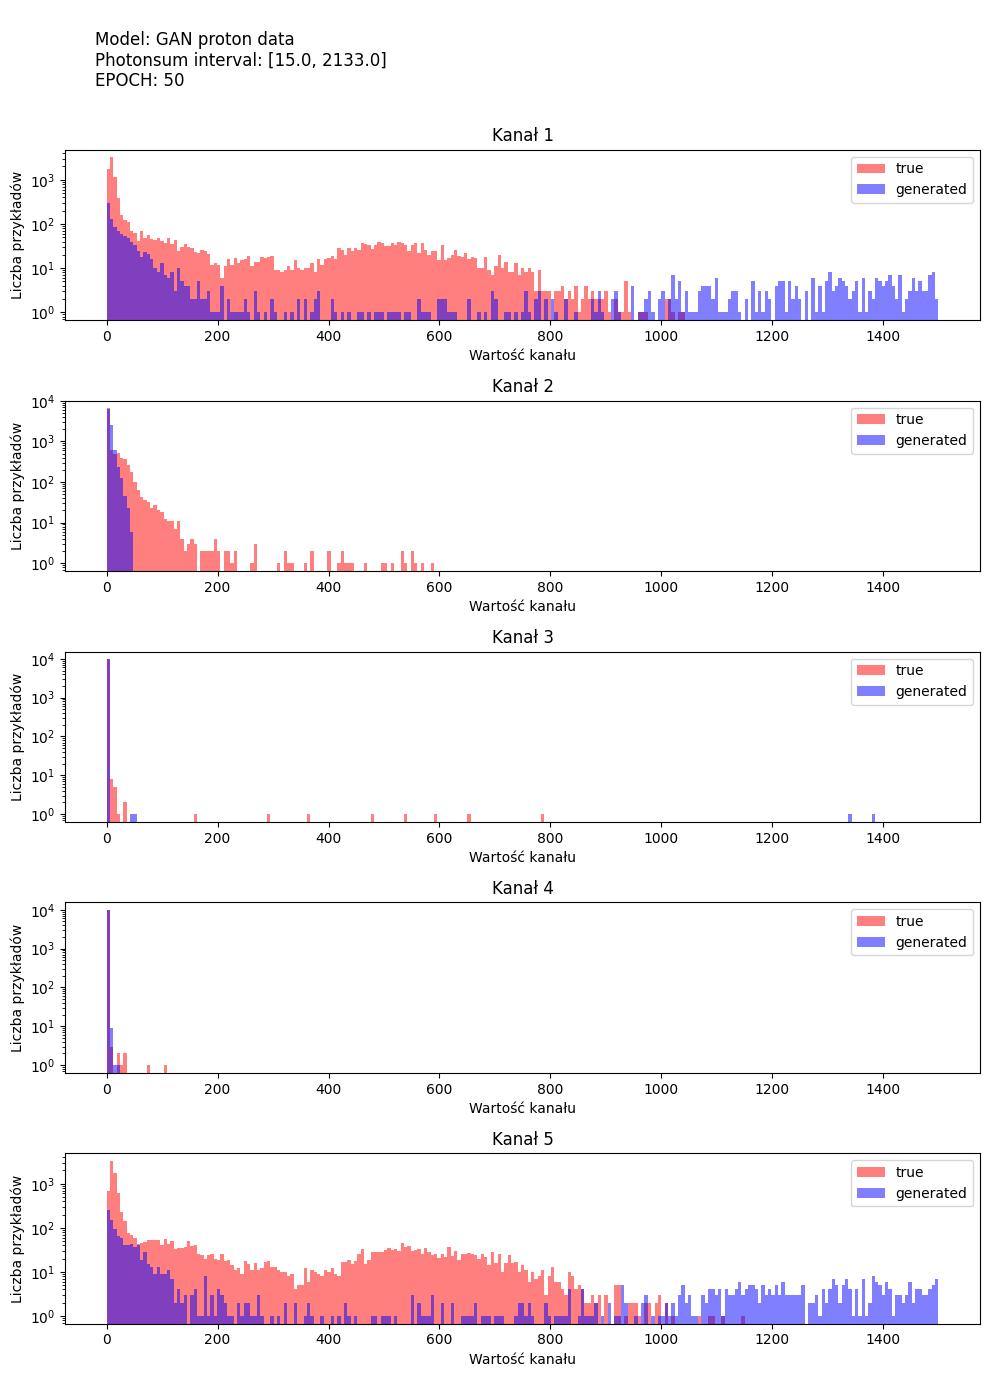

In [17]:
MODEL_FILEPATH = "../experiments/gan_15_2133_27_03_2023_21_24/models/gen_gan_50.h5"

SUPTITLE_TXT = f"\nModel: GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: 50"

make_histograms(SUPTITLE_TXT, MODEL_FILEPATH, 1, 1)

## SDI GAN PROTON NEUTRON PADDED - best model
Generative_Models_for_CERN_Fast_Simulations/experiments/sdi-gan-padded_20_1970_05_07_2023_22_06/models/gen_sdi-gan-padded_62.h5

In [32]:
MODEL_FILEPATH = "../experiments/sdi-gan-padded_20_1970_05_07_2023_22_06/models/gen_sdi-gan-padded_62.h5"

In [34]:
SUPTITLE_TXT = f"\nModel: SDI-GAN proton neutron data" \
               f"\nPhotonsum proton interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nPhotonsum neutron interval: [{photon_sum_neutron_min}, {photon_sum_neutron_max}]" \
               f"\nEPOCH: 62"

make_histograms(SUPTITLE_TXT, MODEL_FILEPATH, 1, 1)

ValueError: in user code:

    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "generator" is incompatible with the layer: expected shape=(None, 9), found shape=(None, 15)


### Sample plots

In [16]:
generator = tf.keras.models.load_model(MODEL_FILEPATH, compile=False)

def generate_and_save_images(model, epoch, test_input):

    SUPTITLE_TXT = f"\nModel: SDI-GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).

    predictions = model(test_input, training=False)

    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[START_GENERATING_IMG_FROM_IDX+i].reshape(56, 30)
        else:
            x = predictions[i-7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.show()

## Examples of central particle response

In [17]:
num_examples_to_generate = 16

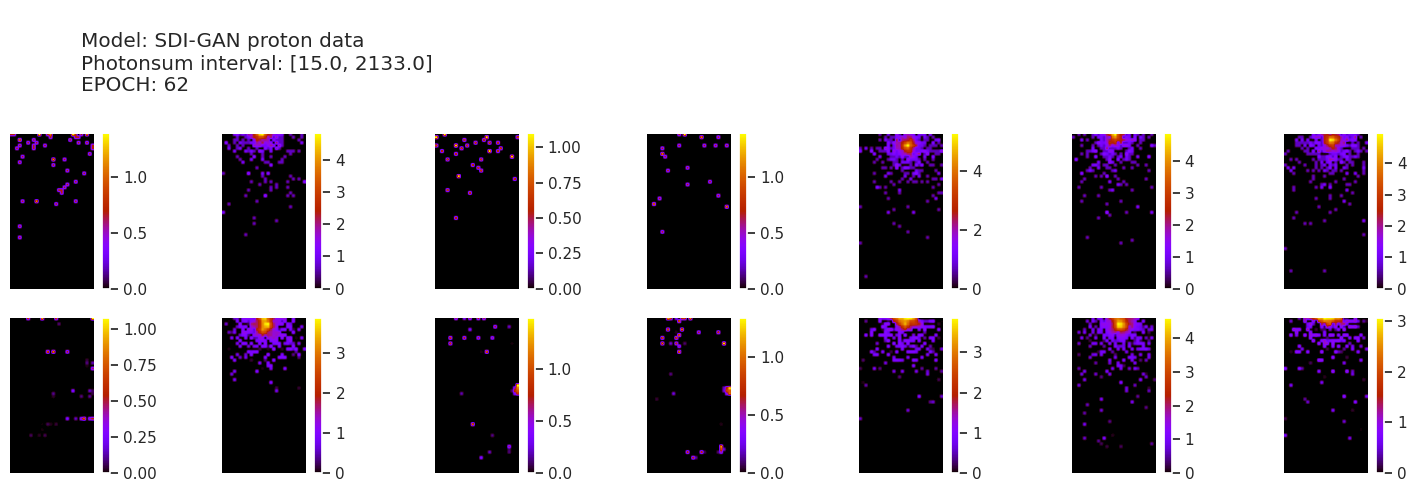

In [18]:
START_GENERATING_IMG_FROM_IDX = 252

seed = tf.random.normal([16, 10])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

generate_and_save_images(generator, 62, [seed, seed_cond])

## Examples of calorimeter not in point responses 

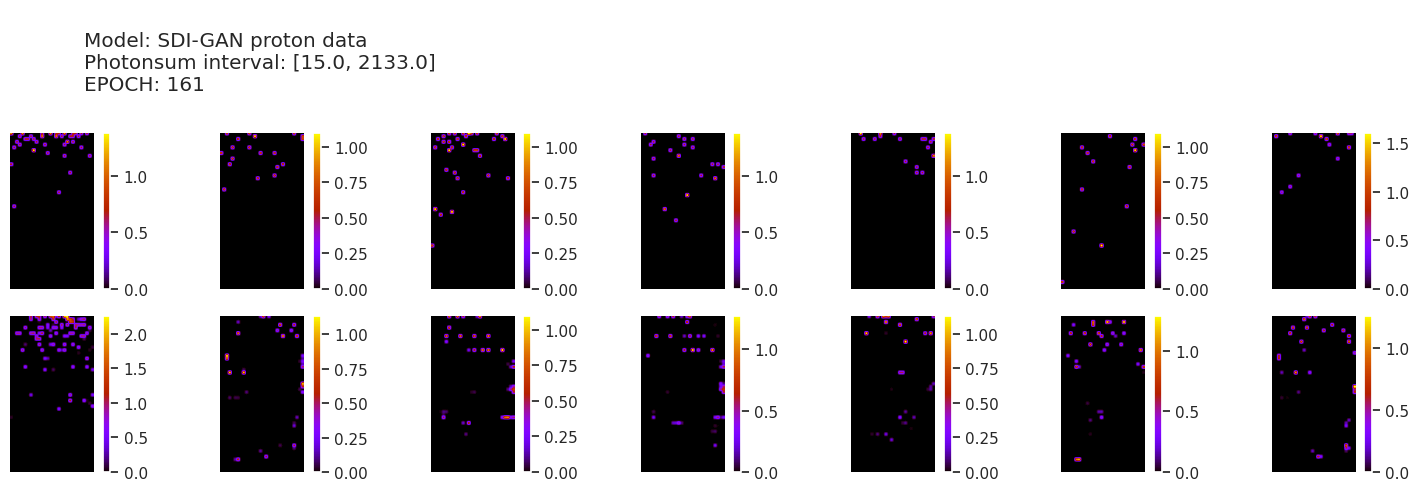

In [19]:
START_GENERATING_IMG_FROM_IDX = 50
seed = tf.random.normal([16, 10])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

generate_and_save_images(generator, 161, [seed, seed_cond])